## Uncertainty estimation with CN


https://www.jmlr.org/papers/volume22/20-1100/20-1100.pdf



In [1]:
import torch
import numpy as np

from torch import optim, nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import matplotlib.pyplot as plt

from tqdm import notebook
from scipy import stats
from scipy.interpolate import interp1d #to invert cdf (CN-g) for sampling

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Simulate dt, Gaussian

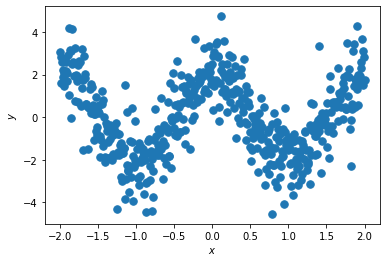

In [3]:
from scipy.stats import norm

n=500
mu=2*torch.cos(torch.linspace(-2,2,n)*3.14159).reshape(-1,1)
sig=torch.rand((n,1))+0.5
x=torch.cat([mu,sig],dim=1)
y=mu+torch.randn((n,1))*sig


plt.plot(torch.linspace(-2,2,n),y,'.',ms=15)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()


class my_dataset(Dataset):
    def __init__(self,data,label):
        self.data=data
        self.label=label         
    def __getitem__(self, index):
        return self.data[index],self.label[index]
    def __len__(self):
        return len(self.data)

## Model

In [4]:
# function to estimate cdf function g(a,x)=p(y<a|x=x), this is the main function to learn uncertainty
class cn_g(nn.Module):
    def __init__(self):
        super().__init__()
        self.k1=80
        self.k2=60
        self.fc1 = nn.Linear(3, self.k1)
        self.fc2 = nn.Linear(self.k1, self.k2)
        self.fc3 = nn.Linear(self.k2, 1)

    def forward(self, q, x):
        data=torch.cat([q,x],dim=1)
        h1 = F.elu(self.fc1(data))
        h2 = F.elu(self.fc2(h1))
        g_q = torch.sigmoid(self.fc3(h2))
        return g_q

# function to estimate inverse cdf function f(p(y<a|x=x),x)=a, this is the space seaching function to assist g
class cn_f(nn.Module):
    def __init__(self):
        super().__init__()
        self.k1=80
        self.k2=60
        self.fc1 = nn.Linear(3, self.k1)
        self.fc2 = nn.Linear(self.k1, self.k2)
        self.fc3 = nn.Linear(self.k2, 1)

    def forward(self, q, x):
        data=torch.cat([q,x],dim=1)
        h1 = F.elu(self.fc1(data))
        h2 = F.elu(self.fc2(h1))
        f_q = self.fc3(h2)
        return f_q

### Train

In [5]:
batch_size=64
dataloader = DataLoader(dataset=my_dataset(x,y),
                            batch_size=batch_size,
                            shuffle=True)

pretrain_epochs =500
epochs = 1000
f = cn_f().to(device)
g = cn_g().to(device)
floss = nn.MSELoss()
gloss = nn.BCELoss()
optimizer_f = optim.Adam(f.parameters(), lr=1e-4)
optimizer_g = optim.Adam(g.parameters(), lr=1e-4)


g_loss=[]
f_loss=[]

# for pretraining, using uniform distribution to search the outcome space and g to learn cdf
val_min=y.min()-2
val_max=y.max()+2

for epoch in notebook.trange(pretrain_epochs):
    for xs, ys in dataloader:
        xs, ys = xs.to(device), ys.to(device)
        optimizer_f.zero_grad()
        optimizer_g.zero_grad()
        
        yhat=torch.rand(ys.shape).to(device)*(val_max-val_min)+val_min #use a uniform distribution covering a wide range for sampling
        qhat = g(yhat,xs)

        with torch.no_grad():
            ylt=ys<yhat #compare random value to observed outcome value and learn cdf
            ylt=ylt.float()
      
        gl = gloss(qhat,ylt)
        gl.backward(retain_graph=True)
        optimizer_g.step()
    g_loss.append(gl.item())

# full training use f(inverse cdf) to explore the space, which is more efficient
# inverse cdf is trained with the fact that g(f(x,q),x)=q
for epoch in notebook.trange(epochs):
    for xs, ys in dataloader:
        xs, ys = xs.to(device), ys.to(device)
        # f update
        optimizer_f.zero_grad()
        optimizer_g.zero_grad()
        q=torch.rand(ys.shape).to(device)  # random percentile
        yhat = f(q,xs) # cooresponding conditional quantile
        qhat = g(yhat,xs)      
        fl = floss(q, qhat)
        fl.backward()
        optimizer_f.step()

        # g update
        optimizer_f.zero_grad()
        optimizer_g.zero_grad()
        q=torch.rand(ys.shape).to(device)  
        yhat = f(q,xs)
        qhat = g(yhat,xs)
        with torch.no_grad():
            ylt=ys<yhat
            ylt=ylt.float()
        gl = gloss(qhat,ylt)
        gl.backward()
        optimizer_g.step()

    g_loss.append(gl.item())
    f_loss.append(fl.item())
    

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

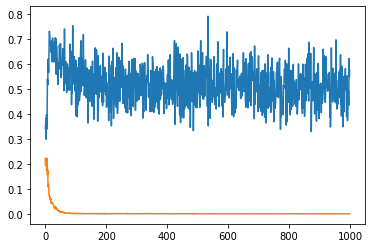

In [6]:
plt.plot(g_loss[500:]) #gloss around 0.5 is a good sign
plt.plot(f_loss)

## Evaluate on some new samples

In [7]:
nt=200
xrange=torch.linspace(-2,2,nt)
mut=2*torch.cos(xrange*3.14159).reshape(-1,1)
sigt=torch.rand((nt,1))+0.5
xt=torch.cat([mut,sigt],dim=1)
yt=mut+torch.randn((nt,1))*sigt

#evaluate to freeze neural networks
f.eval()
g.eval()

cn_g(
  (fc1): Linear(in_features=3, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=1, bias=True)
)

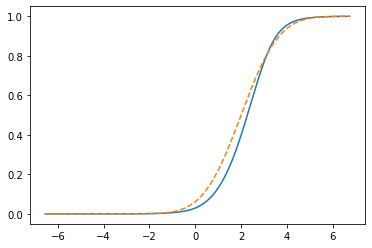

In [8]:
#if it recovers true cdf
yrange=torch.linspace(val_min,val_max,1000).reshape(-1,1)
cdf_est=g(yrange.to(device),xt[0].repeat(1000,1).to(device)).detach()

truecdf=stats.norm.cdf(yrange,mut[0],sigt[0])

plt.plot(yrange,cdf_est,'-')
plt.plot(yrange,truecdf,'--')


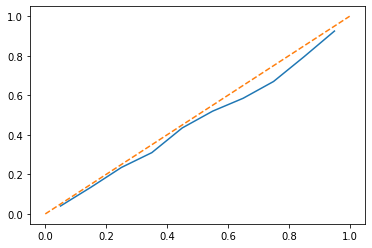

In [9]:
#how well it calibrate the outcome uncertainty
percent=torch.linspace(0.05,0.95,10)
cal=torch.zeros_like(percent)

for i in range(nt):

    #interpolate to get the inverse cdf function to extract quantile
    cdf_est=g(yrange.to(device),xt[i].repeat(1000,1).to(device)).detach().ravel()
    cdf_est[0]=0
    cdf_est[1]=1

    quan_est=interp1d(cdf_est,yrange.ravel())(percent)
    cal+=yt[i].numpy()<quan_est

cal/=nt

plt.plot(percent,cal)
plt.plot([0,1],[0,1],'--')

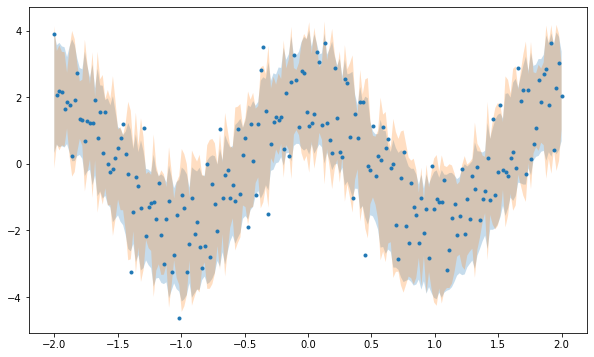

In [10]:
#how well it construct the intervals
percent=torch.Tensor([0.05,0.95])
est_itv=[]
true_itv=[]

for i in range(nt):

    #interpolate to get the inverse cdf function to extract quantile
    cdf_est=g(yrange.to(device),xt[i].repeat(1000,1).to(device)).detach().ravel()
    cdf_est[0]=0
    cdf_est[1]=1

    est_itv.append(interp1d(cdf_est,yrange.ravel())(percent))
    true_itv.append((mut[i]+sigt[i]*stats.norm.ppf([0.05,0.95])).numpy())

est_itv=np.array(est_itv)
true_itv=np.array(true_itv)

plt.figure(figsize=(10,6))
plt.plot(xrange,yt,'.')
plt.fill_between(xrange, est_itv[:,0], est_itv[:,1],alpha=.25)
plt.fill_between(xrange, true_itv[:,0], true_itv[:,1],alpha=.25)